In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datasets import CIFAR_simclr

In [2]:
dataset= "cifar10"
n_epochs= 1000


In [3]:
eval_freq = np.concatenate((np.repeat(1, 100), np.repeat(2, 50),
                                    np.repeat(5, 20), np.repeat(10, 20), np.repeat(20, 25),
                                   np.repeat(50, 20), np.repeat(100,40),
                                    np.repeat(200,20), np.repeat(500, 10)))
if dataset=="cifar100":
    eval_freq= np.concatenate((eval_freq, np.repeat(500, 20)))
idx= np.cumsum(eval_freq)

NameError: name 'np' is not defined

In [7]:
if dataset=="cifar10" or dataset=="cifar100":
    dataset_train= CIFAR_simclr(dataset, n_epochs, train=True)
    dataset_test= CIFAR_simclr(dataset, n_epochs, train=False)
    eval_freq = np.concatenate((np.repeat(1, 100), np.repeat(2, 50),
                                np.repeat(5, 20), np.repeat(10, 20), np.repeat(20, 25),
                               np.repeat(50, 20), np.repeat(100,40),
                                np.repeat(200,20), np.repeat(500, 10), np.repeat(1000, 20)))
    if dataset=="cifar100":
        eval_freq= np.concatenate((eval_freq, np.repeat(500, 20)))
    eval_points= np.cumsum(eval_freq)
len(eval_points)
eval_points.max()




35000

In [79]:
def get_scores(algorithm, run_path, sd):
    run_path= f"{run_path}_{sd}/"
    if algorithm=="full":
        scores= pd.read_csv(run_path +"full.csv", index_col=0)["full_scores"].to_numpy()
    else:
        scores= pd.read_csv(run_path +f"{algorithm}_scores.csv", index_col=0)[f"{algorithm}_scores"].to_numpy()

    return scores.reshape(-1,1)

def get_queries(algorithm, run_path, sd):
    run_path= f"{run_path}_{sd}/"
    queries= pd.read_csv(run_path +f"{algorithm}_queries.csv", index_col=0)[f"{algorithm}_queries"].to_numpy()
    return queries.reshape(-1,1)

def get_degrees(algorithm, run_path, sd):
    assert(algorithm in ["pc", "adpc", "coverpc", "partialadpc"])
    run_path= f"{run_path}_{sd}/"
    df= pd.read_csv(run_path +f"{algorithm}_degrees.csv", index_col=0)
    degrees= df[f"{algorithm}_degrees"].to_numpy()
    options=df[f"{algorithm}_options"].to_numpy()
    return degrees.reshape(-1,1), options.reshape(-1,1)

def get_transition(algorithm, run_path, sd):
    assert(algorithm in ["pc", "adpc", "coverpc", "partialadpc"])
    run_path= f"{run_path}_{sd}/"
    df= pd.read_csv(run_path +f"{algorithm}_degrees.csv", index_col=0)
    degrees= df[f"{algorithm}_degrees"].to_numpy()
    options=df[f"{algorithm}_options"].to_numpy()
    if algorithm=="pc":
        id_min= np.where(degrees==0)[0]
        id_max= None
    if algorithm=="adpc":
        id_min= np.where(degrees==0)[0]
        id_max= np.where(degrees>0)[0][-1]
    return id_min, id_max

def get_radiuses(algorithm, run_path, sd):
    assert(algorithm in ["pc", "adpc", "coverpc", "partialadpc"])
    run_path= f"{run_path}_{sd}/"
    radiuses= np.load(run_path+f"{algorithm}_radiuses.npy")
    return radiuses

def get_covers(algorithm, run_path, sd):
    assert(algorithm in ["pc", "adpc", "coverpc", "partialadpc"])
    run_path= f"{run_path}_{sd}/"
    covers= pd.read_csv(run_path+f"{algorithm}_covers.csv", index_col=0)[f"{algorithm}_covers"].to_numpy()
    return covers.reshape(-1,1)



In [42]:
def get_scores_aggregated(algorithm, run_path, n_seeds):
    scores= np.empty(shape= (len(idx), n_seeds))
    for sd in range(1, n_seeds+1):
        scores[:,sd-1]= get_scores(algorithm, run_path, sd).squeeze()
    return scores.mean(1), scores.std(1)


def get_covers_aggregated(algorithm, run_path, n_seeds):
    covers= np.empty(shape= (len(idx), n_seeds))
    for sd in range(1, n_seeds+1):
        covers[:,sd-1]= get_covers(algorithm, run_path, sd).squeeze()
    return covers.mean(1), covers.std(1)

def get_radiuses_aggregated(algorithm, run_path, n_seeds):
    radiuses= np.empty(shape= (50000, len(idx), n_seeds))
    for sd in range(1, n_seeds+1):
        radiuses[:,:, sd-1]= get_radiuses(algorithm, run_path, sd).squeeze()
    return radiuses, radiuses.mean(-1), radiuses.std(-1)

## Radius decay: mix of optimistic and pessimistic

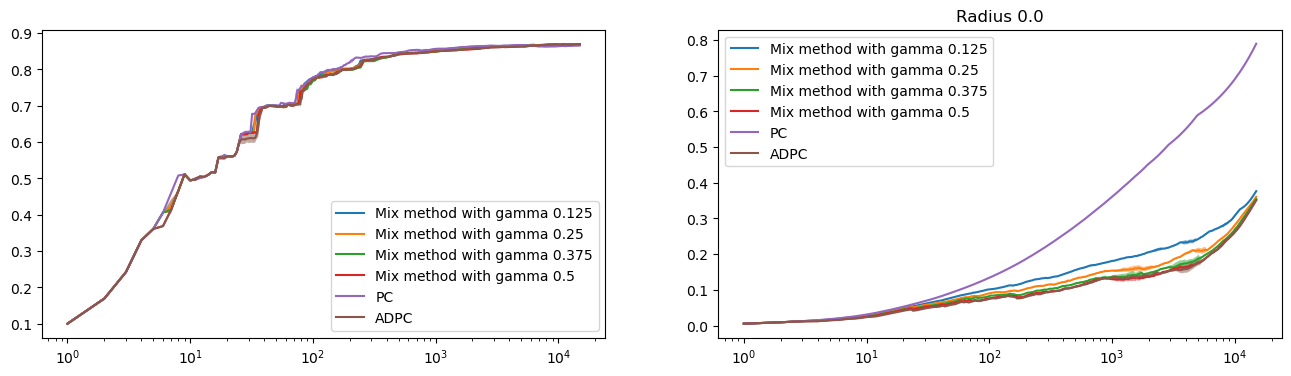

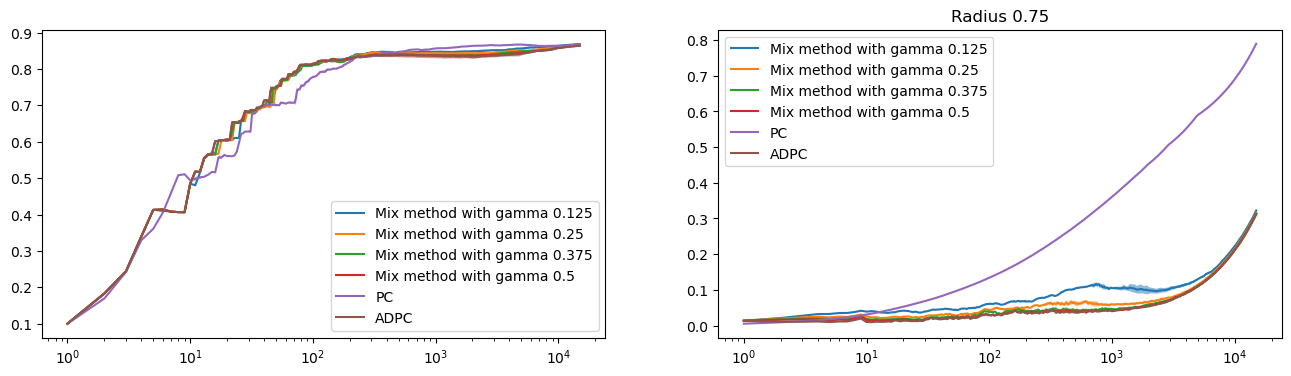

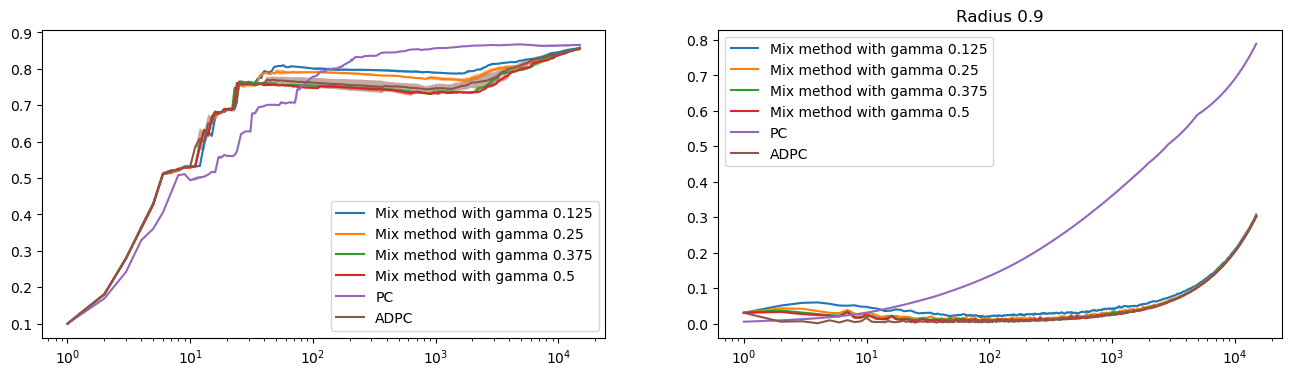

In [60]:

for rad in [0.0, 0.75, 0.9]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    for gamma in [0.125, 0.25, 0.375, 0.5]:
        folder, reduction_method= "mix-runs", "mix"
        run_path_adpc_mix= f"/Users/victoriabarenne/{folder}/{dataset}/1000_4_{rad}_{gamma}_{reduction_method}"
        mean, std= get_scores_aggregated("adpc", run_path_adpc_mix, 5)
        ax1.plot(idx, mean, label= f"Mix method with gamma {gamma}")
        ax1.fill_between(idx, mean+std, mean-std, alpha=0.5)
        mean, std= get_covers_aggregated("adpc", run_path_adpc_mix, 5)
        ax2.plot(idx, mean, label= f"Mix method with gamma {gamma}")
        ax2.fill_between(idx, mean+std, mean-std, alpha=0.5)

    run_path_pc= f"/Users/victoriabarenne/latest/{dataset}/1000_4_0.0"
    run_path_adpc= f"/Users/victoriabarenne/latest-weights/{dataset}/1000_4_{rad}"
    mean_adpc, std_adpc= get_scores_aggregated("adpc", run_path_adpc, 5 )
    mean_pc, std_pc= get_scores_aggregated("pc", run_path_pc, 5 )

    ax1.plot(idx, mean_pc, label= "PC")
    ax1.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax1.plot(idx, mean_adpc, label= "ADPC")
    ax1.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)

    mean_adpc, std_adpc= get_covers_aggregated("adpc", run_path_adpc, 5 )
    mean_pc, std_pc= get_covers_aggregated("pc", run_path_pc, 5 )

    ax2.plot(idx, mean_pc, label= "PC")
    ax2.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax2.plot(idx, mean_adpc, label= "ADPC")
    ax2.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)
    
    ax1.legend()
    ax2.legend()

    ax1.set_xscale("log")
    ax2.set_xscale("log")

    plt.title(label= f'Radius {rad}')
    plt.show()


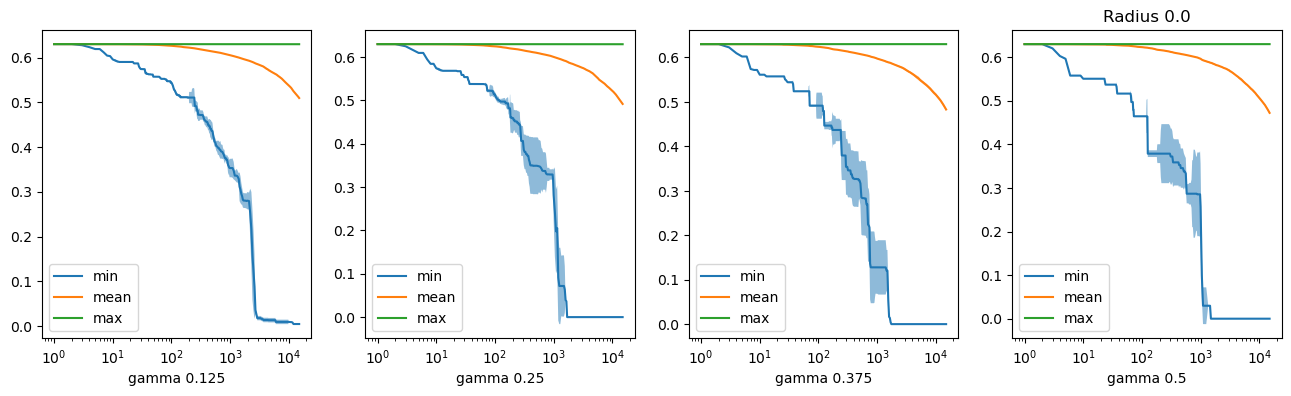

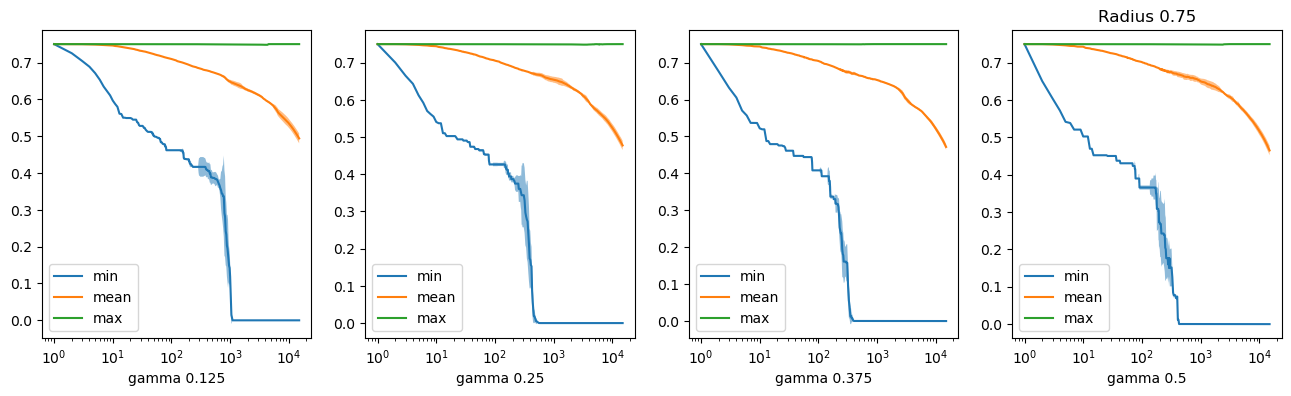

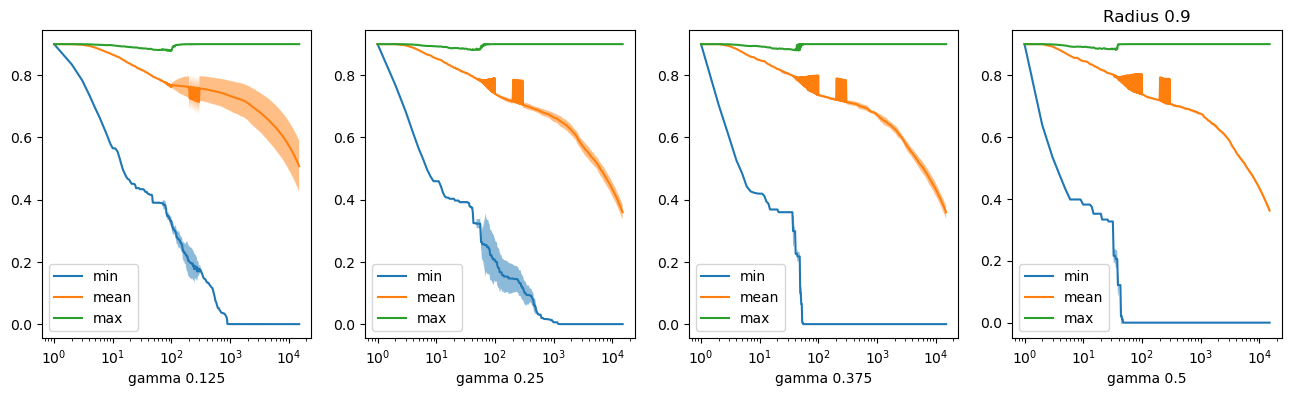

In [56]:

for rad in [0.0, 0.75, 0.9]:
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    i=0
    
    for gamma in [0.125, 0.25, 0.375, 0.5]:
        folder, reduction_method= "mix-runs", "mix"
        run_path_adpc_mix= f"/Users/victoriabarenne/{folder}/{dataset}/1000_4_{rad}_{gamma}_{reduction_method}"
        radiuses, mean, std= get_radiuses_aggregated("adpc", run_path_adpc_mix, 5)

        ax[i].plot(idx, mean.min(0), label= f"min")
        ax[i].fill_between(idx, mean.min(0)+radiuses.min(0).std(-1), mean.min(0)-radiuses.min(0).std(-1), alpha=0.5)
        ax[i].plot(idx, mean.mean(0), label= f"mean")
        ax[i].fill_between(idx, mean.mean(0)+radiuses.mean(0).std(-1), mean.mean(0)-radiuses.mean(0).std(-1), alpha=0.5)
        ax[i].plot(idx, mean.max(0), label= f"max")
        ax[i].fill_between(idx, mean.max(0)+radiuses.max(0).std(-1), mean.max(0)-radiuses.max(0).std(-1), alpha=0.5)
        ax[i].set_xlabel(f"gamma {gamma}")
        i+=1

    for a in ax:
        a.set_xscale("log")
        a.legend()

    run_path_pc= f"/Users/victoriabarenne/latest/{dataset}/1000_4_0.0"
    run_path_adpc= f"/Users/victoriabarenne/latest-weights/{dataset}/1000_4_{rad}"
    mean_adpc, std_adpc= get_scores_aggregated("adpc", run_path_adpc, 5 )
    mean_pc, std_pc= get_scores_aggregated("pc", run_path_pc, 5 )

    ax1.legend()
    ax2.legend()

    ax1.set_xscale("log")
    ax2.set_xscale("log")

    plt.title(label= f'Radius {rad}')
    plt.show()


## Decay radius: changing the weight in radius reduction

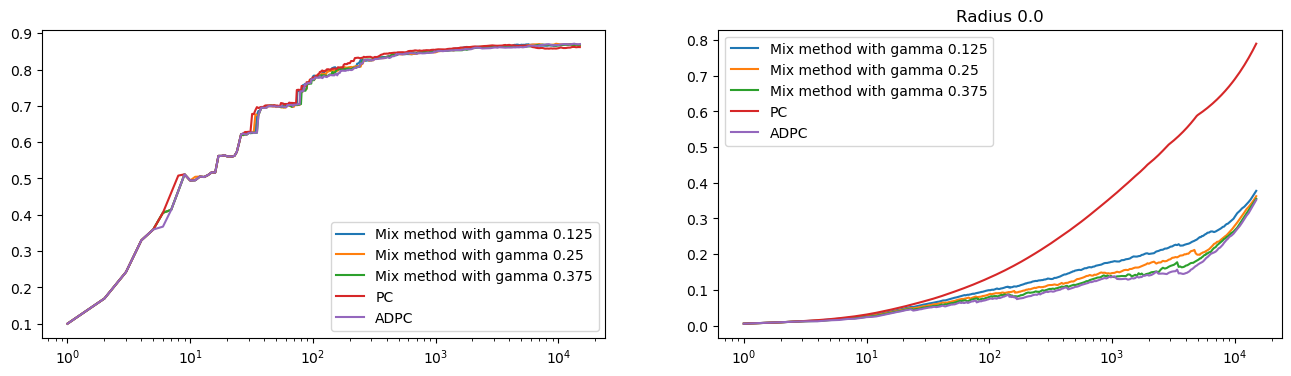

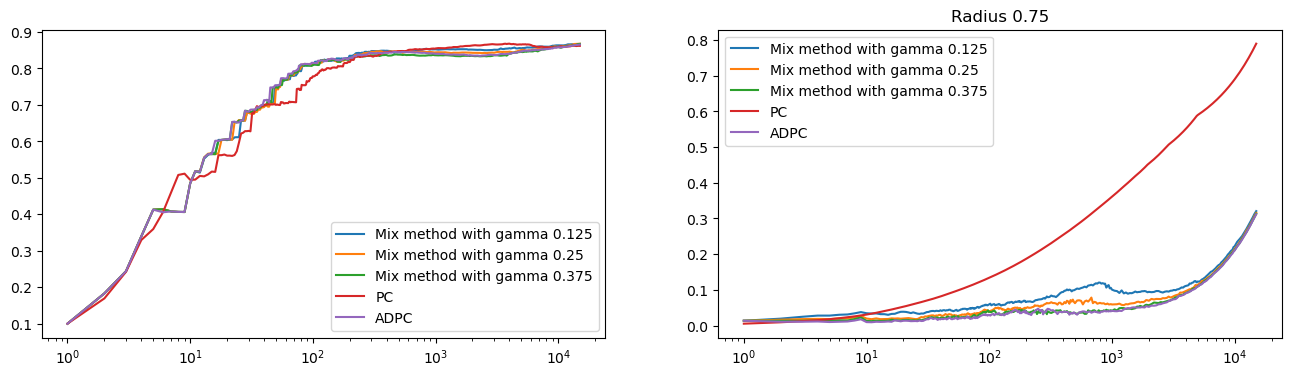

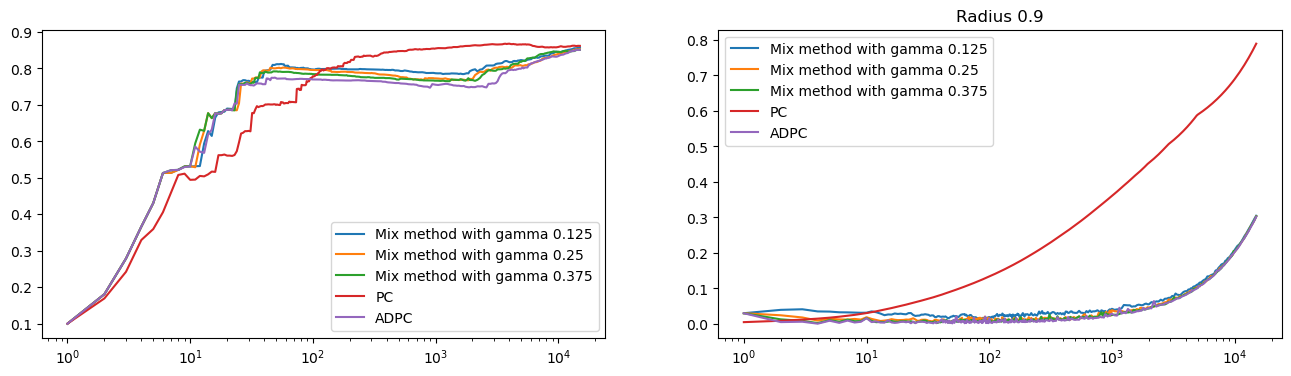

In [63]:
n_seeds= 1

for rad in [0.0, 0.75, 0.9]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    for gamma in [0.125, 0.25, 0.375]:
        folder, reduction_method= "gamma-runs", "pessimistic"
        run_path_adpc_mix= f"/Users/victoriabarenne/{folder}/{dataset}/1000_4_{rad}_{gamma}_{reduction_method}"
        mean, std= get_scores_aggregated("adpc", run_path_adpc_mix, n_seeds)
        ax1.plot(idx, mean, label= f"Mix method with gamma {gamma}")
        ax1.fill_between(idx, mean+std, mean-std, alpha=0.5)
        mean, std= get_covers_aggregated("adpc", run_path_adpc_mix, n_seeds)
        ax2.plot(idx, mean, label= f"Mix method with gamma {gamma}")
        ax2.fill_between(idx, mean+std, mean-std, alpha=0.5)

    run_path_pc= f"/Users/victoriabarenne/latest/{dataset}/1000_4_0.0"
    run_path_adpc= f"/Users/victoriabarenne/latest-weights/{dataset}/1000_4_{rad}"
    mean_adpc, std_adpc= get_scores_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_scores_aggregated("pc", run_path_pc, n_seeds )

    ax1.plot(idx, mean_pc, label= "PC")
    ax1.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax1.plot(idx, mean_adpc, label= "ADPC")
    ax1.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)

    mean_adpc, std_adpc= get_covers_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_covers_aggregated("pc", run_path_pc, n_seeds )

    ax2.plot(idx, mean_pc, label= "PC")
    ax2.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax2.plot(idx, mean_adpc, label= "ADPC")
    ax2.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)
    
    ax1.legend()
    ax2.legend()

    ax1.set_xscale("log")
    ax2.set_xscale("log")

    plt.title(label= f'Radius {rad}')
    plt.show()


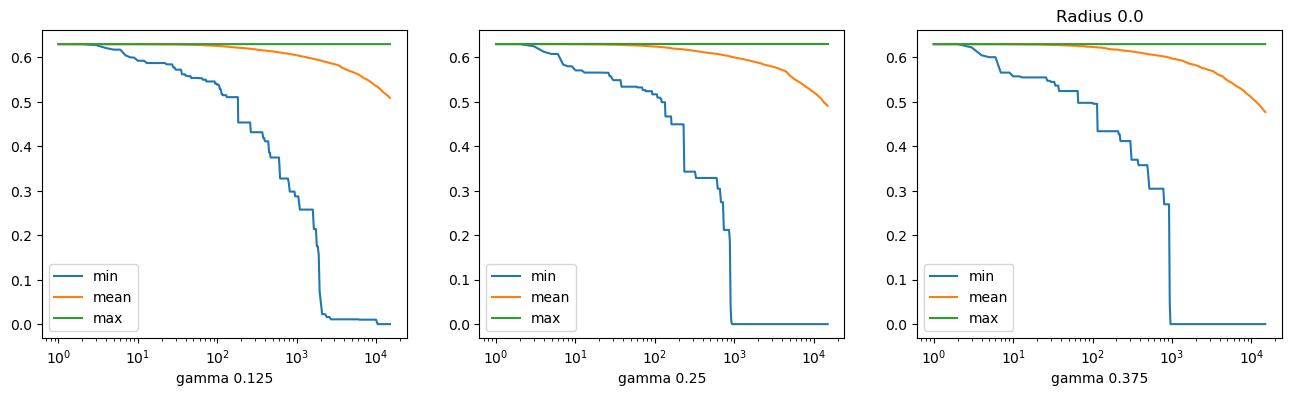

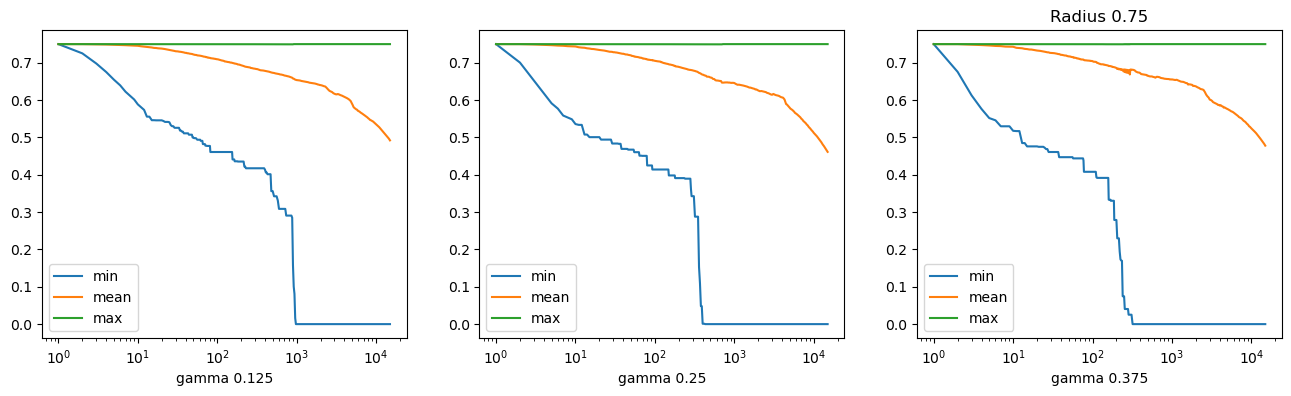

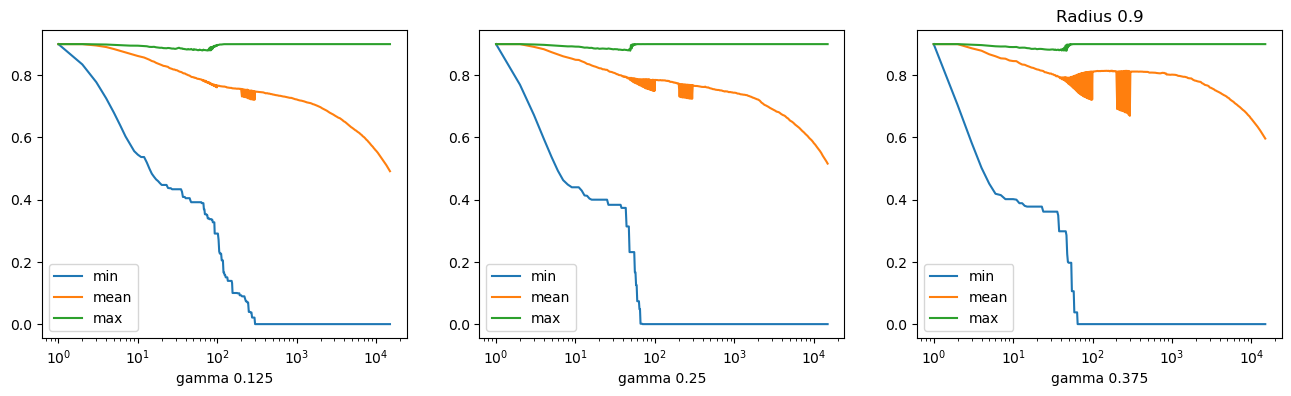

In [66]:

for rad in [0.0, 0.75, 0.9]:
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    i=0
    
    for gamma in [0.125, 0.25, 0.375]:
        folder, reduction_method= "gamma-runs", "pessimistic"
        run_path_adpc_mix= f"/Users/victoriabarenne/{folder}/{dataset}/1000_4_{rad}_{gamma}_{reduction_method}"
        radiuses, mean, std= get_radiuses_aggregated("adpc", run_path_adpc_mix, n_seeds)

        ax[i].plot(idx, mean.min(0), label= f"min")
        ax[i].fill_between(idx, mean.min(0)+radiuses.min(0).std(-1), mean.min(0)-radiuses.min(0).std(-1), alpha=0.5)
        ax[i].plot(idx, mean.mean(0), label= f"mean")
        ax[i].fill_between(idx, mean.mean(0)+radiuses.mean(0).std(-1), mean.mean(0)-radiuses.mean(0).std(-1), alpha=0.5)
        ax[i].plot(idx, mean.max(0), label= f"max")
        ax[i].fill_between(idx, mean.max(0)+radiuses.max(0).std(-1), mean.max(0)-radiuses.max(0).std(-1), alpha=0.5)
        ax[i].set_xlabel(f"gamma {gamma}")
        i+=1

    for a in ax:
        a.set_xscale("log")
        a.legend()

    run_path_pc= f"/Users/victoriabarenne/latest/{dataset}/1000_4_0.0"
    run_path_adpc= f"/Users/victoriabarenne/latest-weights/{dataset}/1000_4_{rad}"
    mean_adpc, std_adpc= get_scores_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_scores_aggregated("pc", run_path_pc, n_seeds )

    ax1.legend()
    ax2.legend()

    ax1.set_xscale("log")
    ax2.set_xscale("log")

    plt.title(label= f'Radius {rad}')
    plt.show()


## Cover PC method

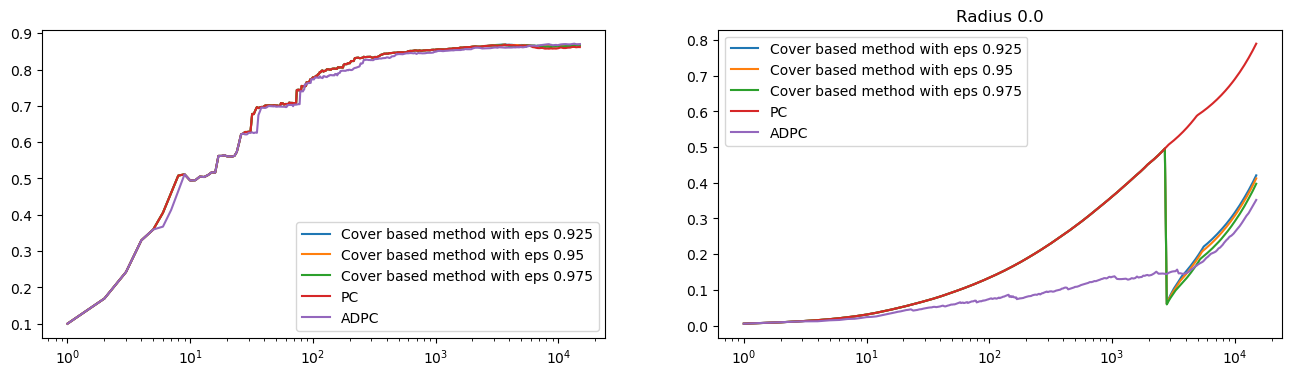

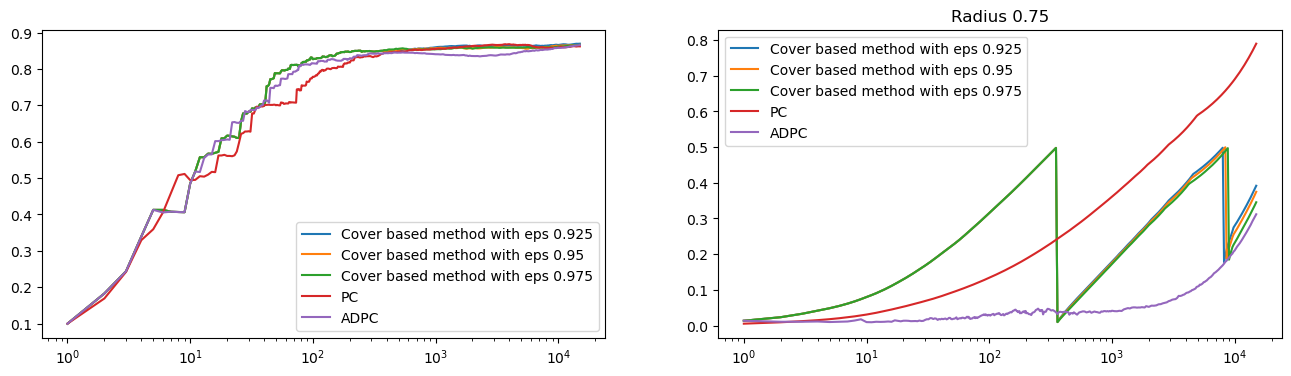

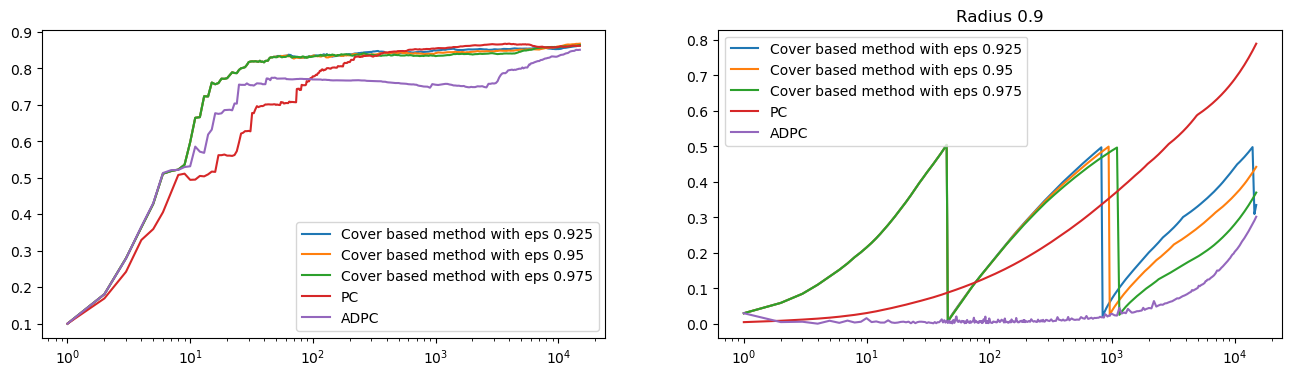

In [70]:
n_seeds= 1

for rad in [0.0, 0.75, 0.9]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    for eps in [0.925, 0.95, 0.975]:
        folder, reduction_method= f"coverpc-runs-{eps}", "pessimistic"
        run_path_adpc_mix= f"/Users/victoriabarenne/{folder}/{dataset}/1000_4_{rad}_0.5_{reduction_method}"
        mean, std= get_scores_aggregated("coverpc", run_path_adpc_mix, n_seeds)
        ax1.plot(idx, mean, label= f"Cover based method with eps {eps}")
        ax1.fill_between(idx, mean+std, mean-std, alpha=0.5)
        mean, std= get_covers_aggregated("coverpc", run_path_adpc_mix, n_seeds)
        ax2.plot(idx, mean, label= f"Cover based method with eps {eps}")
        ax2.fill_between(idx, mean+std, mean-std, alpha=0.5)

    run_path_pc= f"/Users/victoriabarenne/latest/{dataset}/1000_4_0.0"
    run_path_adpc= f"/Users/victoriabarenne/latest-weights/{dataset}/1000_4_{rad}"
    mean_adpc, std_adpc= get_scores_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_scores_aggregated("pc", run_path_pc, n_seeds )

    ax1.plot(idx, mean_pc, label= "PC")
    ax1.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax1.plot(idx, mean_adpc, label= "ADPC")
    ax1.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)

    mean_adpc, std_adpc= get_covers_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_covers_aggregated("pc", run_path_pc, n_seeds )

    ax2.plot(idx, mean_pc, label= "PC")
    ax2.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax2.plot(idx, mean_adpc, label= "ADPC")
    ax2.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)
    
    ax1.legend()
    ax2.legend()

    ax1.set_xscale("log")
    ax2.set_xscale("log")

    plt.title(label= f'Radius {rad}')
    plt.show()


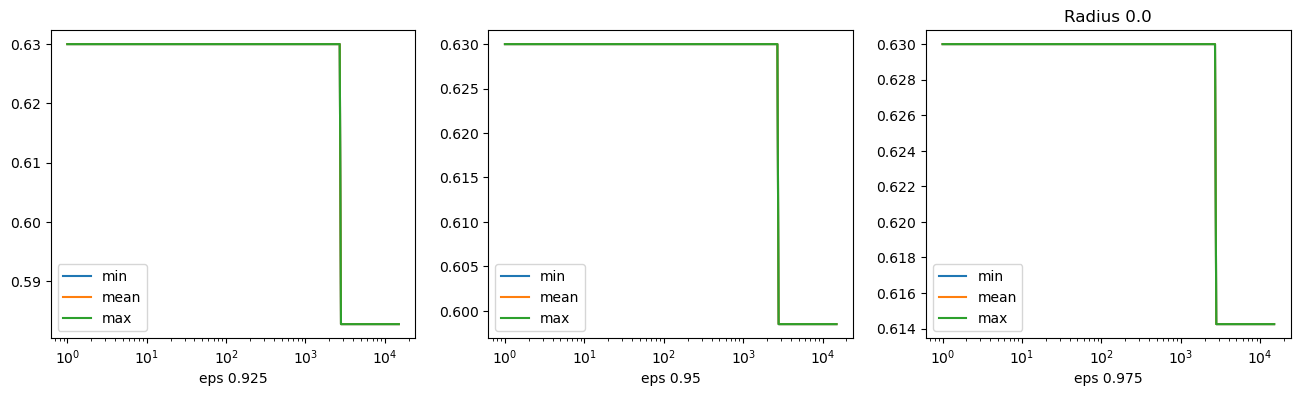

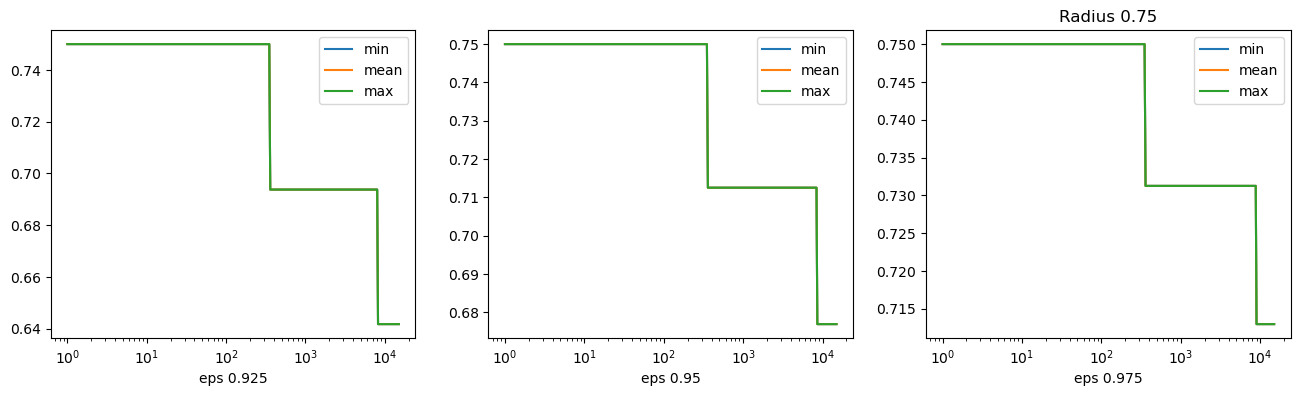

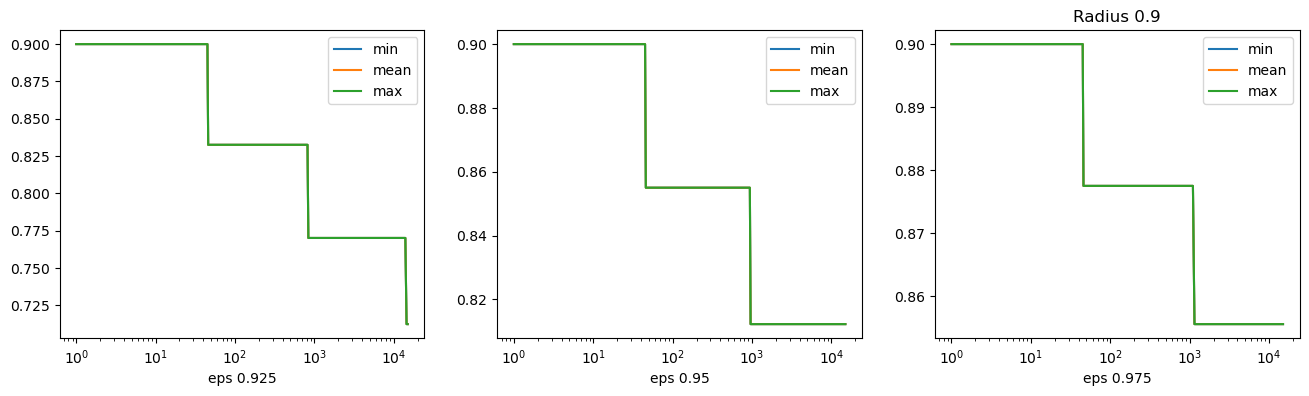

In [96]:

for rad in [0.0, 0.75, 0.9]:
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    i=0
    
    for eps in [0.925, 0.95, 0.975]:
        folder, reduction_method= f"coverpc-runs-{eps}", "pessimistic"
        run_path_adpc_mix= f"/Users/victoriabarenne/{folder}/{dataset}/1000_4_{rad}_0.5_{reduction_method}"
        radiuses, mean, std= get_radiuses_aggregated("coverpc", run_path_adpc_mix, n_seeds)

        ax[i].plot(idx, mean.min(0), label= f"min")
        ax[i].fill_between(idx, mean.min(0)+radiuses.min(0).std(-1), mean.min(0)-radiuses.min(0).std(-1), alpha=0.5)
        ax[i].plot(idx, mean.mean(0), label= f"mean")
        ax[i].fill_between(idx, mean.mean(0)+radiuses.mean(0).std(-1), mean.mean(0)-radiuses.mean(0).std(-1), alpha=0.5)
        ax[i].plot(idx, mean.max(0), label= f"max")
        ax[i].fill_between(idx, mean.max(0)+radiuses.max(0).std(-1), mean.max(0)-radiuses.max(0).std(-1), alpha=0.5)
        ax[i].set_xlabel(f"eps {eps}")
        i+=1

    for a in ax:
        a.set_xscale("log")
        a.legend()

    run_path_pc= f"/Users/victoriabarenne/latest/{dataset}/1000_4_0.0"
    run_path_adpc= f"/Users/victoriabarenne/latest-weights/{dataset}/1000_4_{rad}"
    mean_adpc, std_adpc= get_scores_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_scores_aggregated("pc", run_path_pc, n_seeds )

    ax1.legend()
    ax2.legend()

    ax1.set_xscale("log")
    ax2.set_xscale("log")

    plt.title(label= f'Radius {rad}')
    plt.show()


## Partial ADPC method

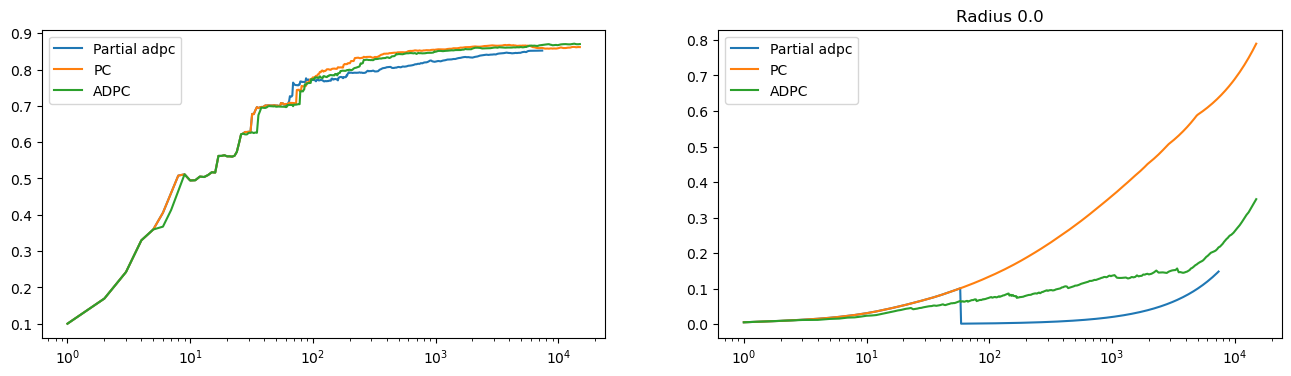

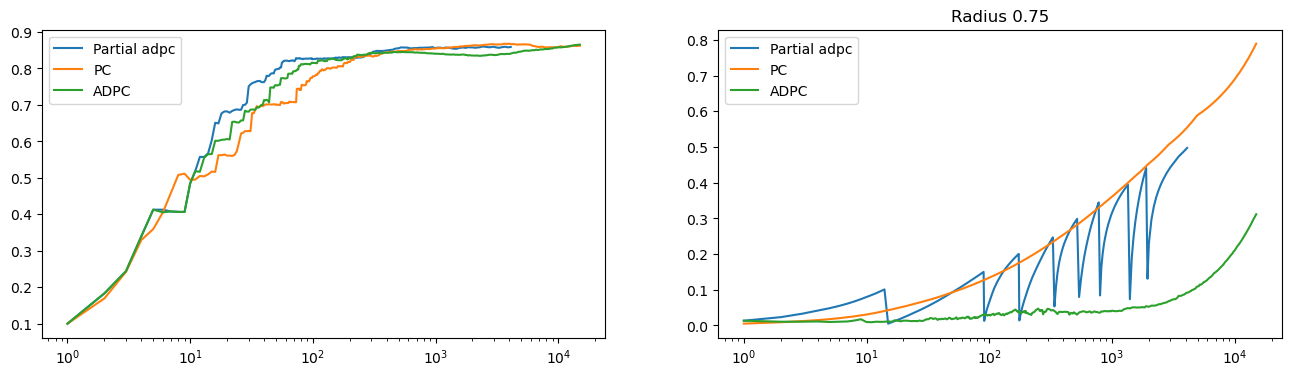

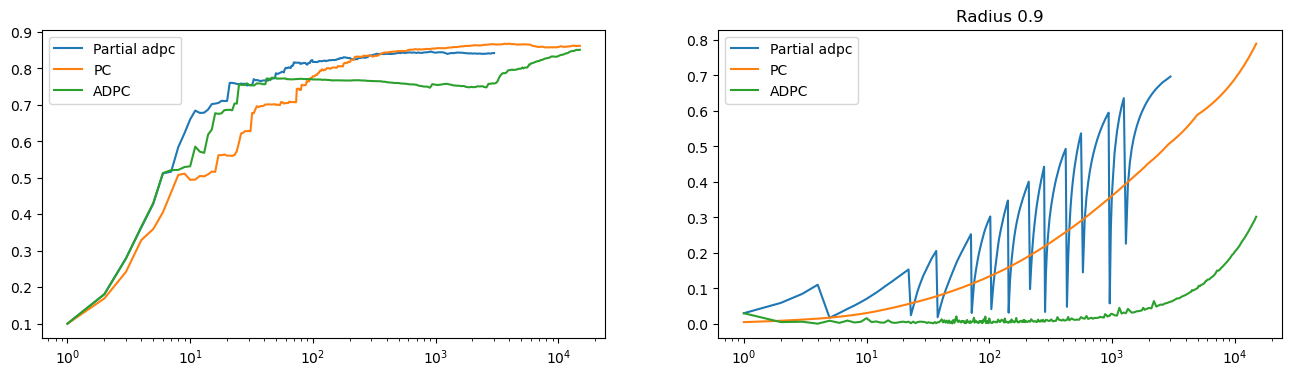

In [95]:
n_seeds= 1

for rad in [0.0, 0.75, 0.9]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    folder, reduction_method= f"partialadpc", "pessimistic"
    run_path_adpc_mix= f"/Users/victoriabarenne/{folder}/{dataset}/1000_4_{rad}_0.5_{reduction_method}"
    mean = get_scores("partialadpc", run_path_adpc_mix, n_seeds)
    ax1.plot(idx[:len(mean)], mean, label= f"Partial adpc")
    mean= get_covers("partialadpc", run_path_adpc_mix, n_seeds)
    ax2.plot(idx[:len(mean)], mean, label= f"Partial adpc")

    run_path_pc= f"/Users/victoriabarenne/latest/{dataset}/1000_4_0.0"
    run_path_adpc= f"/Users/victoriabarenne/latest-weights/{dataset}/1000_4_{rad}"
    mean_adpc, std_adpc= get_scores_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_scores_aggregated("pc", run_path_pc, n_seeds )

    ax1.plot(idx, mean_pc, label= "PC")
    ax1.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax1.plot(idx, mean_adpc, label= "ADPC")
    ax1.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)

    mean_adpc, std_adpc= get_covers_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_covers_aggregated("pc", run_path_pc, n_seeds )

    ax2.plot(idx, mean_pc, label= "PC")
    ax2.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax2.plot(idx, mean_adpc, label= "ADPC")
    ax2.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)
    
    ax1.legend()
    ax2.legend()

    ax1.set_xscale("log")
    ax2.set_xscale("log")

    plt.title(label= f'Radius {rad}')
    plt.show()


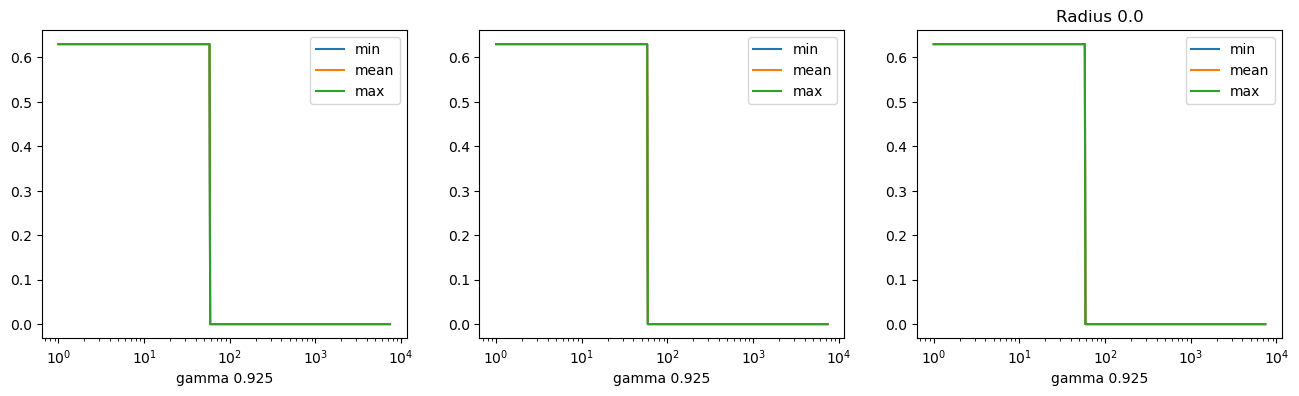

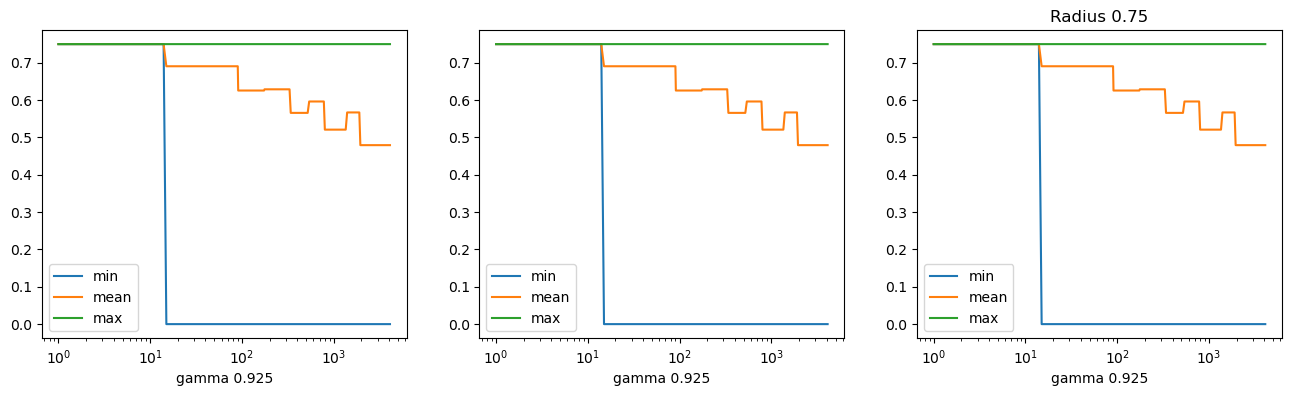

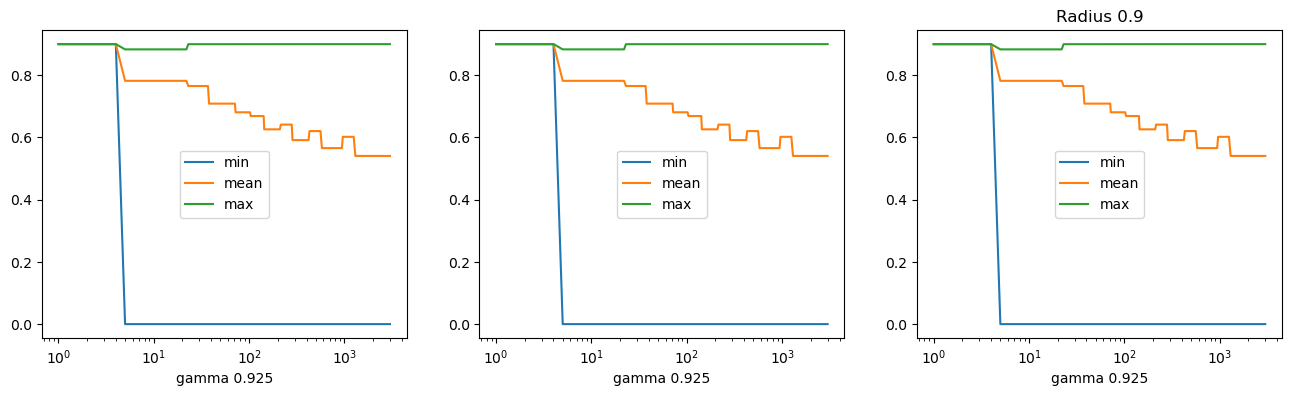

In [92]:

for rad in [0.0, 0.75, 0.9]:
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    i=0
    
    for eps in [0.925, 0.95, 0.975]:
        folder, reduction_method= "partialadpc", "pessimistic"
        run_path_adpc_mix= f"/Users/victoriabarenne/{folder}/{dataset}/1000_4_{rad}_0.5_{reduction_method}"
        radiuses = get_radiuses("partialadpc", run_path_adpc_mix, 1)
        mean= radiuses
        ax[i].plot(idx[:len(mean.min(0))], mean.min(0), label= f"min")
        ax[i].plot(idx[:len(mean.min(0))], mean.mean(0), label= f"mean")
        ax[i].plot(idx[:len(mean.min(0))], mean.max(0), label= f"max")
        ax[i].set_xlabel(f"gamma {gamma}")
        i+=1

    for a in ax:
        a.set_xscale("log")
        a.legend()

    run_path_pc= f"/Users/victoriabarenne/latest/{dataset}/1000_4_0.0"
    run_path_adpc= f"/Users/victoriabarenne/latest-weights/{dataset}/1000_4_{rad}"
    mean_adpc, std_adpc= get_scores_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_scores_aggregated("pc", run_path_pc, n_seeds )

    ax1.legend()
    ax2.legend()

    ax1.set_xscale("log")
    ax2.set_xscale("log")

    plt.title(label= f'Radius {rad}')
    plt.show()


## Hard-thresholding

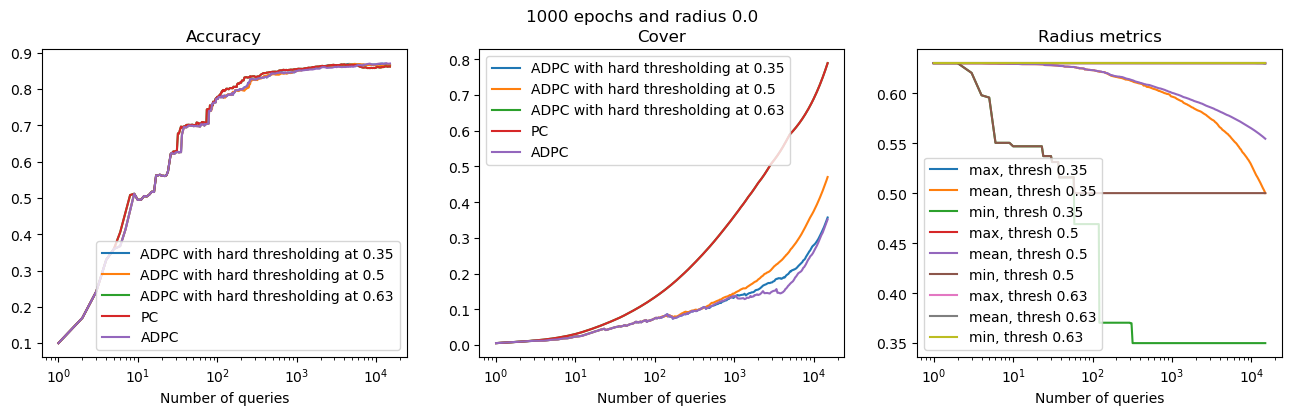

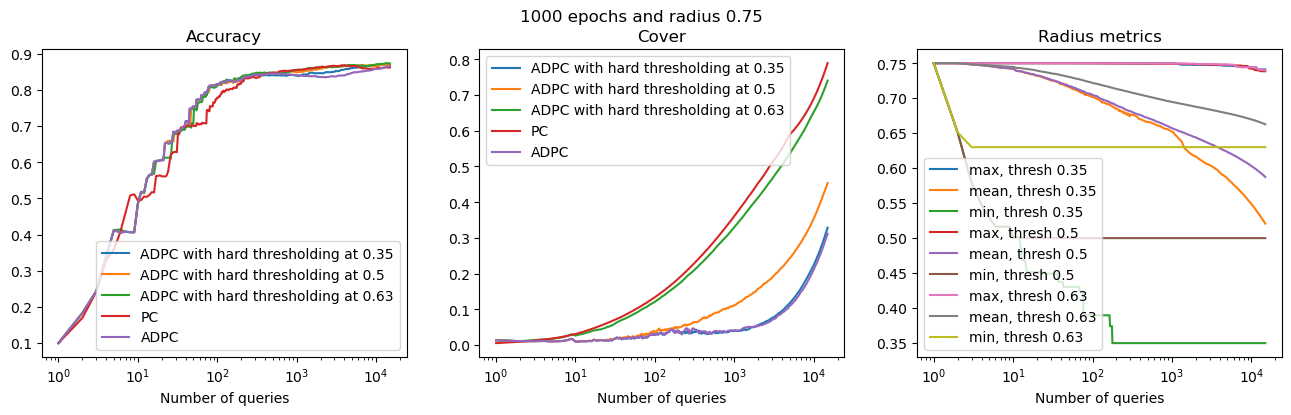

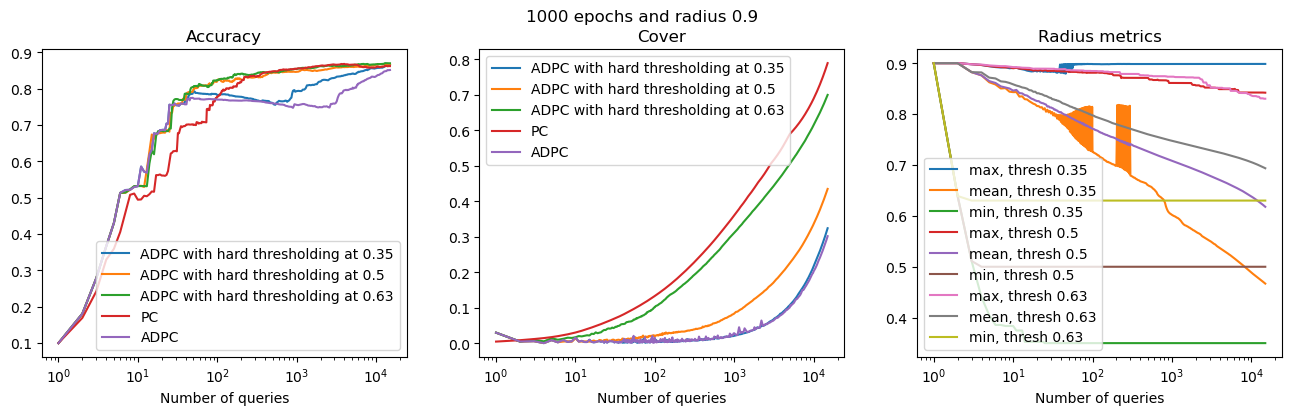

In [124]:
hard_threshold= 0.35


n_seeds= 1

for rad in [0.0, 0.75, 0.9]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

    for hard_threshold in [0.35, 0.5, 0.63]:
    
        folder, reduction_method= f"adpc-hardthresholding_{hard_threshold}", "pessimistic"

        run_path_adpc_mix= f"/Users/victoriabarenne/thesis_experiments/{folder}/{dataset}/1000_4_{rad}_{0.5}_{reduction_method}"

        mean, std= get_scores_aggregated("adpc", run_path_adpc_mix, n_seeds)
        ax1.plot(idx, mean, label= f"ADPC with hard thresholding at {hard_threshold}")
        ax1.fill_between(idx, mean+std, mean-std, alpha=0.5)
        
        mean, std= get_covers_aggregated("adpc", run_path_adpc_mix, n_seeds)
        ax2.plot(idx, mean, label= f"ADPC with hard thresholding at {hard_threshold}")
        ax2.fill_between(idx, mean+std, mean-std, alpha=0.5)

        radiuses, mean, std= get_radiuses_aggregated("adpc", run_path_adpc_mix, n_seeds)
        ax3.plot(idx, mean.max(0), label = f"max, thresh {hard_threshold}")
        ax3.plot(idx, mean.mean(0), label = f"mean, thresh {hard_threshold}")
        ax3.plot(idx, mean.min(0), label = f"min, thresh {hard_threshold}")

    run_path_pc= f"/Users/victoriabarenne/thesis_experiments/latest/{dataset}/1000_4_0.0"
    run_path_adpc= f"/Users/victoriabarenne/thesis_experiments/latest-weights/{dataset}/1000_4_{rad}"
    mean_adpc, std_adpc= get_scores_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_scores_aggregated("pc", run_path_pc, n_seeds )
    ax1.plot(idx, mean_pc, label= "PC")
    ax1.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax1.plot(idx, mean_adpc, label= "ADPC")
    ax1.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)

    mean_adpc, std_adpc= get_covers_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_covers_aggregated("pc", run_path_pc, n_seeds )
    ax2.plot(idx, mean_pc, label= "PC")
    ax2.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax2.plot(idx, mean_adpc, label= "ADPC")
    ax2.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)


    
    for ax in [ax1, ax2, ax3]:
        ax.legend()
        ax.set_xscale("log")
        ax.set_xlabel("Number of queries")
    ax1.title.set_text(f"Accuracy")
    ax2.title.set_text(f"Cover")
    ax3.title.set_text(f"Radius metrics")



    fig.suptitle(f"{n_epochs} epochs and radius {rad}")
    plt.show()


## Comparing Cover PC and Partial ADPC


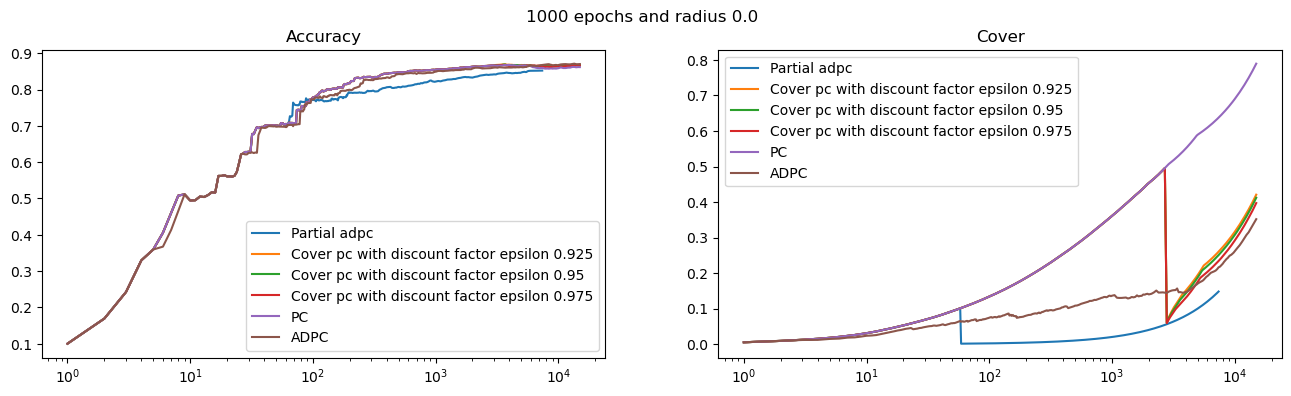

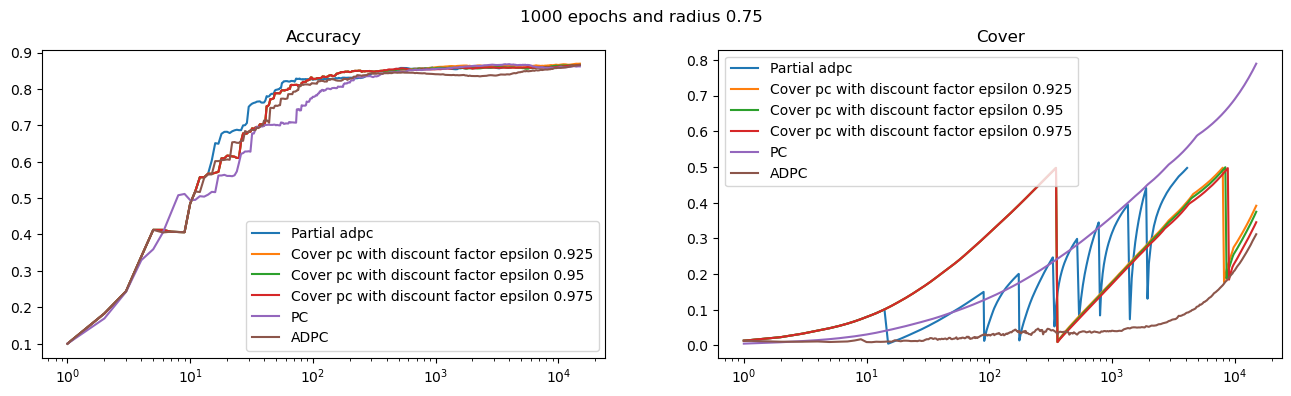

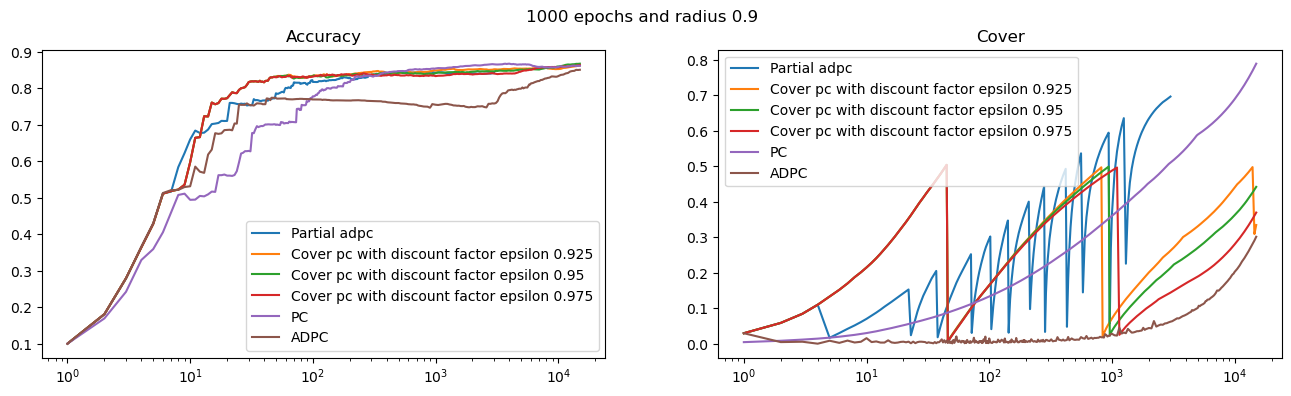

In [114]:
n_seeds= 1

for rad in [0.0, 0.75, 0.9]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    folder, reduction_method= f"partialadpc", "pessimistic"
    run_path_partialadpc= f"/Users/victoriabarenne/{folder}/{dataset}/1000_4_{rad}_0.5_{reduction_method}"
    mean = get_scores("partialadpc", run_path_partialadpc, n_seeds)
    ax1.plot(idx[:len(mean)], mean, label= f"Partial adpc")
    mean= get_covers("partialadpc", run_path_partialadpc, n_seeds)
    ax2.plot(idx[:len(mean)], mean, label= f"Partial adpc")
    for eps in [0.925, 0.95, 0.975]:
        run_path_coverpc= f"/Users/victoriabarenne/coverpc-runs-{eps}/{dataset}/1000_4_{rad}_0.5_{reduction_method}"
        mean = get_scores("coverpc", run_path_coverpc, n_seeds)
        ax1.plot(idx[:len(mean)], mean, label= f"Cover pc with discount factor epsilon {eps}")
        mean= get_covers("coverpc", run_path_coverpc, n_seeds)
        ax2.plot(idx[:len(mean)], mean, label= f"Cover pc with discount factor epsilon {eps}")

    run_path_pc= f"/Users/victoriabarenne/latest/{dataset}/1000_4_0.0"
    run_path_adpc= f"/Users/victoriabarenne/latest-weights/{dataset}/1000_4_{rad}"
    mean_adpc, std_adpc= get_scores_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_scores_aggregated("pc", run_path_pc, n_seeds )

    ax1.plot(idx, mean_pc, label= "PC")
    ax1.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax1.plot(idx, mean_adpc, label= "ADPC")
    ax1.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)

    mean_adpc, std_adpc= get_covers_aggregated("adpc", run_path_adpc, n_seeds )
    mean_pc, std_pc= get_covers_aggregated("pc", run_path_pc, n_seeds )

    ax2.plot(idx, mean_pc, label= "PC")
    ax2.fill_between(idx, mean_pc+std_pc, mean_pc-std_pc, alpha=0.5)
    ax2.plot(idx, mean_adpc, label= "ADPC")
    ax2.fill_between(idx, mean_adpc+std_adpc, mean_adpc-std_adpc, alpha=0.5)
    
    for ax in [ax1, ax2]:
        ax.legend()
        ax.set_xscale("log")

    ax1.title.set_text(f"Accuracy")
    ax2.title.set_text(f"Cover")

    fig.suptitle(f"{n_epochs} epochs and radius {rad}")
    plt.show()
